In [2]:
import pandas as pd
import numpy as np
import requests
#from bs4 import BeautifulSoup
import os
#!conda install -c conda-forge folium=0.5.0 --yes
import folium 
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns

print('Done!')

Done!


function to get the geocodes i.e latitude and longitude of a given location using geopy

In [3]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

# a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude

In [4]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = '0TW4A0AYOG3W2ATLCPFTR2I12PVLMJTRORMVI3SU5V3KC35E' # your Foursquare ID
    CLIENT_SECRET = 'OIUW4DFTGZUWI0YMEQ4NYQQDLKKVLEVODPHO3FIRKDVFBQDM' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    print("done")
    return df

# a function to get venue details like like count , rating , tip counts for a given venue id

In [5]:
def get_venue_details(venue_id):
        
    CLIENT_ID = '0TW4A0AYOG3W2ATLCPFTR2I12PVLMJTRORMVI3SU5V3KC35E' # your Foursquare ID
    CLIENT_SECRET = 'OIUW4DFTGZUWI0YMEQ4NYQQDLKKVLEVODPHO3FIRKDVFBQDM' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

# a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [6]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

# get new york data

In [7]:
new_york_data=get_new_york_data()
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
new_york_data.shape


(306, 4)

# we can visulaise this neighbrohood

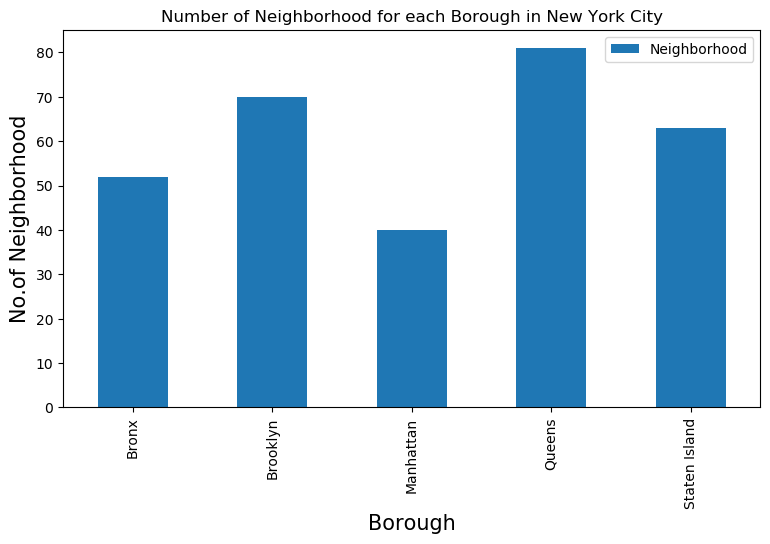

In [9]:

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Queens has highest number of neighborhoods

Now we will collect Italian resturants for each Neighborhood

In [10]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
ital_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    ital_resturants=venues[venues['Category']=='Italian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Italian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(ital_resturants)))
    for resturant_detail in ital_resturants.values.tolist():
        id, name , category=resturant_detail
        ital_rest_ny = ital_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

done
( 1 / 306 ) Italian Restaurants in Wakefield, Bronx:0
done
( 2 / 306 ) Italian Restaurants in Co-op City, Bronx:0
done
( 3 / 306 ) Italian Restaurants in Eastchester, Bronx:0
done
( 4 / 306 ) Italian Restaurants in Fieldston, Bronx:0
done
( 5 / 306 ) Italian Restaurants in Riverdale, Bronx:1
done
( 6 / 306 ) Italian Restaurants in Kingsbridge, Bronx:1
done
( 7 / 306 ) Italian Restaurants in Marble Hill, Manhattan:1
done
( 8 / 306 ) Italian Restaurants in Woodlawn, Bronx:2
done
( 9 / 306 ) Italian Restaurants in Norwood, Bronx:0
done
( 10 / 306 ) Italian Restaurants in Williamsbridge, Bronx:0
done
( 11 / 306 ) Italian Restaurants in Baychester, Bronx:2
done
( 12 / 306 ) Italian Restaurants in Pelham Parkway, Bronx:3
done
( 13 / 306 ) Italian Restaurants in City Island, Bronx:3
done
( 14 / 306 ) Italian Restaurants in Bedford Park, Bronx:0
done
( 15 / 306 ) Italian Restaurants in University Heights, Bronx:0
done
( 16 / 306 ) Italian Restaurants in Morris Heights, Bronx:0
done
( 17 /

In [11]:
ital_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Riverdale,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria
1,Bronx,Kingsbridge,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria
2,Manhattan,Marble Hill,511b54f17ab47b5a3cc69aec,Mr. Nicks Pizza & Pasta
3,Bronx,Woodlawn,511edb6de4b0d58346fd272d,Patrizia's Of Woodlawn
4,Bronx,Woodlawn,4d3cb3026b3d236a066a6364,Rivers Edge


In [12]:
ital_rest_ny.shape

(524, 4)

We got 524 Italian Resturants across New York City

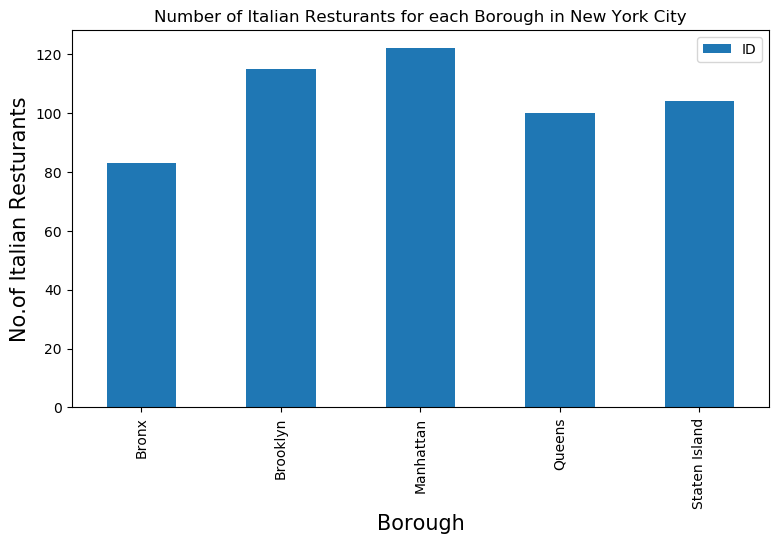

In [13]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Italian Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Italian Resturants', fontsize=15)
#giving a bar plot
ital_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Manhattan and Brooklyn has the largest number of italian resturants

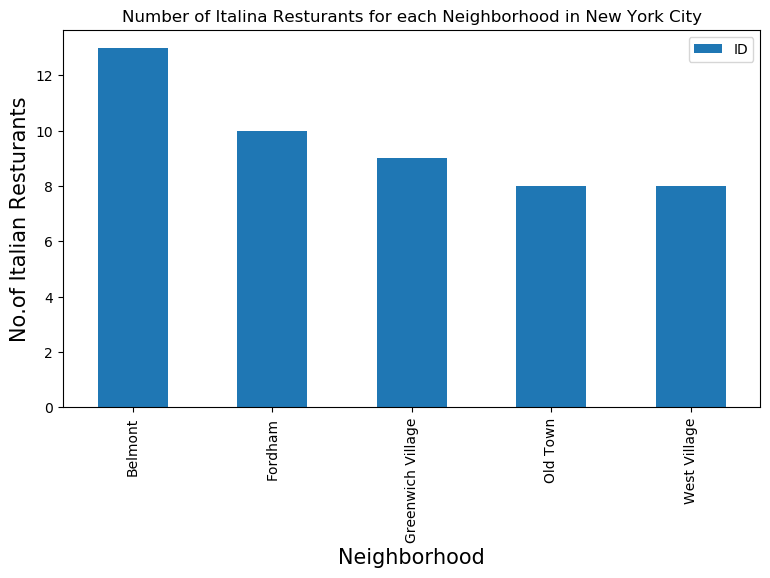

In [14]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Italina Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Italian Resturants', fontsize=15)
#giving a bar plot
ital_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [16]:

ital_rest_ny[ital_rest_ny['Neighborhood']=='Belmont']

,Borough,Neighborhood,ID,Name
44,Bronx,Belmont,4acf80aef964a52025d420e3,Tino's Delicatessen
45,Bronx,Belmont,4af71916f964a520cf0522e3,Michaelangelo's Coal Fired Brick Oven Pizza Re...
46,Bronx,Belmont,4bb6470cef159c7465b275f7,Calabria Pork Store
47,Bronx,Belmont,59050f51b23dfa5f6649e678,Arthur Avenue Fiasco
48,Bronx,Belmont,4af0fa29f964a52060e021e3,Antonio's Trattoria
49,Bronx,Belmont,4aa425bef964a5208e4520e3,Dominick's Restaurant
50,Bronx,Belmont,4b5514c4f964a5207cda27e3,Enzo's
51,Bronx,Belmont,4a8e261cf964a5201c1220e3,Roberto's
52,Bronx,Belmont,4c79d294278eb713f6a05580,Cafe al Mercato
53,Bronx,Belmont,4b5a4c8ff964a52049bb28e3,Emilia's Restaurant


So Belmont in Bronx has the highest number of Indian Resturants with a total count of 13.

Now we will get the ranking of each resturant for further analysis.

In [44]:
# prepare neighborhood list that contains italian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
ital_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in ital_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(ital_rest_ny),')','processed')
    ital_rest_stats_ny = ital_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID                  Name  Likes  Rating  Tips
0  55aaee4d498e3cbb70e625d6  Bella Notte Pizzeria      9     7.3     4
( 1 / 524 ) processed
                         ID                  Name  Likes  Rating  Tips
0  55aaee4d498e3cbb70e625d6  Bella Notte Pizzeria      9     7.3     4
( 2 / 524 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 511b54f17ab47b5a3cc69aec
( 3 / 524 ) processed
                         ID                    Name  Likes  Rating  Tips
0  511edb6de4b0d58346fd272d  Patrizia's Of Woodlawn     18     8.5    14
( 4 / 524 ) processed
                         ID         Name  Likes  Rating  Tips
0  4d3cb3026b3d236a066a6364  Rivers Edge     10     6.8     8
( 5 / 524 ) processed
                         ID        Name  Likes  Rating  Tips
0  4c9518076b35a143d5dc21dc  Fratelli's     22     8.6     6
( 6 / 524 ) processed
                         ID          Name  Likes  Rating  Tips
0  5411894d

KeyError: 'venue'

In [45]:
ital_rest_stats_ny.head()


,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Riverdale,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria,9,7.3,4
1,Bronx,Kingsbridge,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria,9,7.3,4
2,Manhattan,Marble Hill,0,0,0,0.0,0
3,Bronx,Woodlawn,511edb6de4b0d58346fd272d,Patrizia's Of Woodlawn,18,8.5,14
4,Bronx,Woodlawn,4d3cb3026b3d236a066a6364,Rivers Edge,10,6.8,8


In [46]:
ital_rest_stats_ny.shape


(50, 7)

In [47]:

ital_rest_ny.shape

(524, 4)

So we got data for all resturants Now lets save this data to a csv sheet. In case we by mistake modify it. As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required

In [48]:
ital_rest_stats_ny.to_csv('ital_rest_stats_ny.csv', index=False)


In [49]:
ital_rest_stats_ny_csv=pd.read_csv('ital_rest_stats_ny.csv')


In [50]:
ital_rest_stats_ny_csv.shape

(50, 7)

In [51]:
ital_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Riverdale,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria,9,7.3,4
1,Bronx,Kingsbridge,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria,9,7.3,4
2,Manhattan,Marble Hill,0,0,0,0.0,0
3,Bronx,Woodlawn,511edb6de4b0d58346fd272d,Patrizia's Of Woodlawn,18,8.5,14
4,Bronx,Woodlawn,4d3cb3026b3d236a066a6364,Rivers Edge,10,6.8,8


In [52]:
ital_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       50 non-null     object 
 1   Neighborhood  50 non-null     object 
 2   ID            50 non-null     object 
 3   Name          50 non-null     object 
 4   Likes         50 non-null     object 
 5   Rating        50 non-null     float64
 6   Tips          50 non-null     object 
dtypes: float64(1), object(6)
memory usage: 2.9+ KB


We see that values like Likes, Tips are strig values. We would need to convert them into float for further analysis



In [53]:
ital_rest_stats_ny['Likes']=ital_rest_stats_ny['Likes'].astype('float64')
ital_rest_stats_ny['Tips']=ital_rest_stats_ny['Tips'].astype('float64')

In [54]:
# Resturant with maximum Likes
ital_rest_stats_ny.iloc[ital_rest_stats_ny['Likes'].idxmax()]

Borough                            Bronx
Neighborhood                    Van Nest
ID              3fd66200f964a5207bf11ee3
Name                   F & J Pine Tavern
Likes                                176
Rating                               8.6
Tips                                  72
Name: 37, dtype: object

In [55]:
# Resturant with maximum Tips
ital_rest_stats_ny.iloc[ital_rest_stats_ny['Tips'].idxmax()]

Borough                            Bronx
Neighborhood                    Van Nest
ID              3fd66200f964a5207bf11ee3
Name                   F & J Pine Tavern
Likes                                176
Rating                               8.6
Tips                                  72
Name: 37, dtype: object

In [56]:
# Resturant with maximum Rating
ital_rest_stats_ny.iloc[ital_rest_stats_ny['Rating'].idxmax()]

Borough                            Bronx
Neighborhood                     Fordham
ID              4acf80aef964a52025d420e3
Name                 Tino's Delicatessen
Likes                                145
Rating                               9.2
Tips                                  48
Name: 13, dtype: object

In [81]:
ny_neighborhood_stats=ital_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [68]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)


,Neighborhood,Average Rating
1,Belmont,8.683333
4,Fordham,8.150000
0,Baychester,8.000000
14,Van Nest,8.000000
9,Morrisania,8.000000
11,Pelham Parkway,7.866667
16,Woodlawn,7.650000
2,City Island,7.566667
8,Morris Park,7.540000
7,Melrose,7.500000


Above are the top Neighborhoods with top average rating of Italian resturants



In [83]:
ny_borough_stats=ital_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [79]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()


,Borough,Average Rating
0,Bronx,7.746939
1,Manhattan,0.000000


Similarly these are the average rating of Italian Resturants for each Borough

Lets visualize it

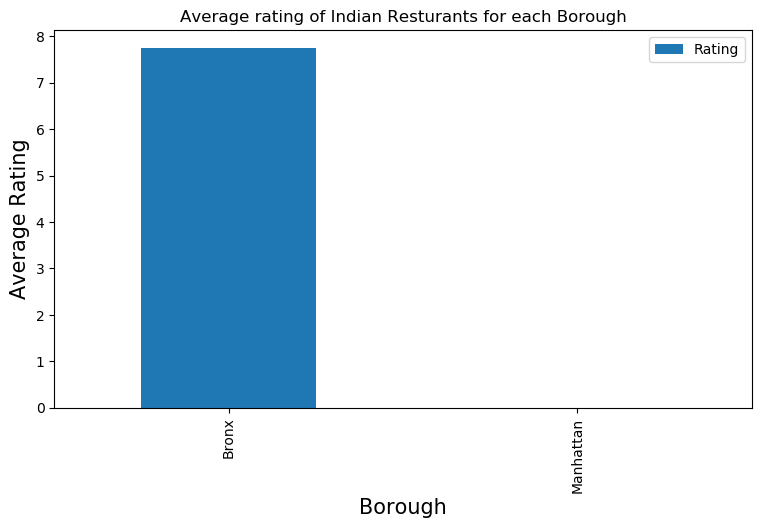

In [61]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
ital_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal 9.0 to visualize on map



In [86]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats


,Neighborhood,Average Rating
0,Baychester,8.000000
1,Belmont,8.683333
4,Fordham,8.150000
9,Morrisania,8.000000
14,Van Nest,8.000000


We will join this dataset to original new york data to get lonitude and latitude



In [87]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats


,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Bronx,Baychester,40.866858,-73.835798,8.000000
1,Bronx,Belmont,40.857277,-73.888452,8.683333
2,Bronx,Fordham,40.860997,-73.896427,8.150000
3,Bronx,Morrisania,40.823592,-73.901506,8.000000
4,Bronx,Van Nest,40.843608,-73.866299,8.000000


Show this data on a map



In [88]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [89]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Lets add a new field to dataframe for labeling purpose



In [90]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'


In [91]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

Now that we have visualized the Neighborhoods. Lets Visualize Boroughs based on average Rating



In [101]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'Borough Boundaries.geojson'

ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# display map
# as this is huge map data , we will save it to a file
ny_map.save('italina borough_rating.html')

### Conclusion

Manhattan and Queens have the best rated Italian restaurants on average and  Queens and The Bronx have the least amount of Italian restaurants per borough. However, of note, Belmont of The Bronx is the neighborhood in all of NYC with the most Italian Restaurants. Despite Manhattan having the least number of neighborhoods in all five boroughs, it has the most Italian restaurants. Based on this information, I would state that Manhattan and Queens are the best locations for Italian cuisine in NYC. To have the best shot of success, I would open an Italian restaurants in Queens. 
Queens has multiple neighborhoods with average ratings exceeding 8.0 of a scale of 1.0 to 10.0 and has the least number of Italian restaurants making competition easier than in other boroughs. 